In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

from structure_vb_lib import structure_model_lib, posterior_quantities_lib

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
out_filename='huang2011_fit'
out_folder='../fits/hgdp_fits/'

# data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
# out_filename = 'huang2011_fit_sub'
# out_folder = '../fits/tmp/'


In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
print(data_file)

../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz


In [6]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

# Load initial fit

In [7]:
print(init_fit_file)

../fits/hgdp_fits/huang2011_fit_alpha6.0.npz


In [8]:
vb_init_dict, vb_params_paragami, _, _, \
    gh_loc, gh_weights, init_fit_meta_data = \
        structure_model_lib.load_structure_fit(init_fit_file)

### initial expected cluster weights

In [9]:
e_n_loci_init = posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs,
                                                    vb_init_dict, 
                                                    gh_loc,
                                                    gh_weights)

In [10]:
e_n_ind_init = posterior_quantities_lib.get_e_num_ind_per_cluster(vb_init_dict, gh_loc, gh_weights)

# Some helper functions to load and plot posterior statistics

In [11]:
refit_color = '#d95f02'
lr_color = '#1b9e77'

### Functions to plot expected number of observations per cluster

In [12]:
def load_e_num_obs_all(perturbation): 
    
    match_crit = out_filename + '_' + perturbation + '\d+_poststats.npz'
    ps_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    assert len(ps_files) > 0

    def load_key(key): 
        array = []
        
        for i in range(len(ps_files)): 
            post_stats = np.load(out_folder + ps_files[i])
            array.append(post_stats[key].squeeze())
                        
        return np.array(array)

    # load epsilons
    epsilon_vec = load_key('epsilon')
    
    # permutation to put epsilons in order
    indx = onp.argsort(epsilon_vec)
    
    # get expected number of obs under refit
    n_loci_refit = load_key('e_n_loci_refit')[indx] 
    n_ind_refit = load_key('e_n_ind_refit')[indx] 
    
    # get expected number of obs under lr
    n_loci_lr = load_key('e_n_loci_lr')[indx] 
    n_ind_lr = load_key('e_n_ind_lr')[indx]

    return n_loci_refit, n_ind_refit, \
            n_loci_lr, n_ind_lr, epsilon_vec[indx]

In [32]:
def plot_e_num_obs(e_num_refit, e_num_lr, e_num_init, ax, thresh = None, ylab = ''): 
    
    k_approx = len(e_num_refit)
    
    xvec = np.arange(k_approx)
    
    # plot init
    ax.plot(xvec, 
            e_num_init, 
            '-o', 
            label = 'init', 
            color = 'lightblue')
    
    # plot refit
    ax.plot(xvec, 
            e_num_refit, 
            '-o', 
            color = 'red',
            label = 'refit')
    
    # plot lr
    ax.plot(xvec, 
            e_num_lr, 
            ':x', 
            color = 'red',
            label = 'lr')
    
    ax.set_ylabel(ylab)
    ax.set_xlabel('k')
    
    if thresh is not None: 
        ax.axhline(thresh, color = 'grey')
        
    ax.set_xticks(np.arange(k_approx, step = 5))
    
    ax.semilogy()
    

In [14]:
def plot_e_num_obs_for_perturbation(perturbation): 
    e_n_loci_refit, e_n_ind_refit, \
        e_n_loci_lr, e_n_ind_lr, _ = \
            load_e_num_obs_all(perturbation)
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4)) 
    
    which_epsilon = -1
    
    k_approx = len(e_n_loci_refit[which_epsilon])
    
    # number of loci    
    plot_e_num_obs(e_n_loci_refit[which_epsilon], 
                   e_n_loci_lr[which_epsilon], 
                   e_n_loci_init, 
                   ax[0], 
                   thresh = 500., 
                   ylab = 'expected n. loci')
    ax[0].legend()
    
    # number of individuals
    plot_e_num_obs(e_n_ind_refit[which_epsilon], 
                   e_n_ind_lr[which_epsilon], 
                   e_n_ind_init, 
                   ax[1], 
                   thresh = 1, 
                   ylab = 'expected n. individuals')
    fig.tight_layout()

In [55]:
def plot_e_num_obs_trace_for_perturbation(perturbation, plot_n_loci = True): 
    e_n_loci_refit, e_n_ind_refit, \
        e_n_loci_lr, e_n_ind_lr, epsilon_vec = \
            load_e_num_obs_all(perturbation)
    
    if plot_n_loci: 
        refit = e_n_loci_refit
        lr = e_n_loci_lr
    else: 
        refit = e_n_ind_refit
        lr = e_n_ind_lr
        
    fig, ax = plt.subplots(4, 5, figsize = (12, 8), sharex = True) 
    
    for k in range(e_n_loci_refit.shape[-1]): 
        ax[k // 5, k % 5].plot(epsilon_vec, 
                               refit[:, k], 
                               '-o',
                               color = refit_color, 
                               label = 'refit')
        ax[k // 5, k % 5].plot(epsilon_vec, 
                               lr[:, k], 
                               '-o',
                               color = lr_color, 
                               label = 'lr')
        ax[k // 5, k % 5].set_title('k = {}'.format(k))
        
        if k == 0: 
            ax[k // 5, k % 5].legend()
            
    for k in range(5): 
        ax[-1, k].set_xlabel('epsilon')
        
    for k in range(4): 
        ax[k, 0].set_ylabel('E(# loci)')
    
    fig.tight_layout()

### Functions to plot expected number of clusters

In [49]:
def load_e_num_clusters_vec(perturbation): 
    match_crit = out_filename + '_' + perturbation + '\d+_poststats.npz'
    ps_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    assert len(ps_files) > 0
    
    def load_key(key): 
        vec = onp.zeros(len(ps_files))
        
        for i in range(len(ps_files)): 
            post_stats = np.load(out_folder + ps_files[i])
            vec[i] = post_stats[key].squeeze()
            
                        
        return vec

    # load epsilons
    epsilon_vec = load_key('epsilon')
    
    # permutation to put epsilons in order
    indx = onp.argsort(epsilon_vec)
    
    # get expected number of clusters under refit
    nc_refit_vec = load_key('e_n_clusters_refit2')[indx] # number of in-sample clusters (thresholded)
    npc_refit_vec = load_key('e_n_pred_clusters_refit')[indx] # num. predictive clusters
    npct_refit_vec = load_key('e_n_pred_clusters_refit_thresh')[indx] # pred. clusters thresholded
    
    # get expected number of clusters under lr
    nc_lr_vec = load_key('e_n_clusters_lr2')[indx]
    npc_lr_vec = load_key('e_n_pred_clusters_lr')[indx]
    npct_lr_vec = load_key('e_n_pred_clusters_lr_thresh')[indx]
    
    return nc_refit_vec, npc_refit_vec, npct_refit_vec,\
            nc_lr_vec, npc_lr_vec, npct_lr_vec,\
                epsilon_vec[indx]

In [50]:
def plot_e_num_clusters(refit_vec, lr_vec, epsilon_vec, ax, ylab = ''): 
    ax.plot(epsilon_vec, 
           refit_vec, 
           'o-', 
           color = refit_color,
           label = 'refit')

    ax.plot(epsilon_vec,
               lr_vec, 
               'o-', 
               color = lr_color,
               label = 'lr')
    
    ax.set_xlabel('epsilon')
    ax.set_ylabel(ylab)
    ax.legend()

In [51]:
def plot_e_num_clusters_for_perturbation(perturbation): 
    fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 

    nc_refit_vec, npc_refit_vec, npct_refit_vec,\
        nc_lr_vec, npc_lr_vec, npct_lr_vec,\
            epsilon_vec = load_e_num_clusters_vec(perturbation)

    plot_e_num_clusters(refit_vec = nc_refit_vec, 
                        lr_vec = nc_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[0], 
                        ylab = 'n. insample clusters (thresh)')


    plot_e_num_clusters(refit_vec = npc_refit_vec, 
                        lr_vec = npc_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[1], 
                        ylab = 'n. pred clusters')
    
    plot_e_num_clusters(refit_vec = npct_refit_vec, 
                        lr_vec = npct_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[2], 
                        ylab = 'n pred clusters (thresh)')

# Function to plot the perturbation

In [52]:

def plot_perturbation(perturbation): 
    
    if 'sigmoidal' in perturbation: 
        delta = 5.0
    else: 
        delta = 1.0
        
    lr_data = np.load(lr_file)
    alpha0 = lr_data['alpha0']
    
    logit_v_grid = np.array(lr_data['logit_v_grid'])
    influence_grid = np.array(lr_data['influence_grid'])

    # get functional perturbation objectives
    # a lot of arguments are "none" because we just 
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = None, 
                                                 alpha0 = alpha0,
                                                 gh_loc = None, 
                                                 gh_weights = None,
                                                 logit_v_grid = logit_v_grid, 
                                                 influence_grid = influence_grid, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();
    
    return prior_perturbation

In [53]:
def load_e_num_obs_per_cluster(perturbation): 
    
    # load fit at epsilon = 1
    ps_file = out_filename + '_' + perturbation + '18_poststats.npz'
    post_stats = np.load(out_folder + ps_file)
    assert post_stats['epsilon'] == 1
    
    
    return post_stats['e_n_loci_refit'], post_stats['e_n_loci_lr'], \
            post_stats['e_n_ind_refit'], post_stats['e_n_ind_lr']

# Plot results

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.677581e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.750940e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


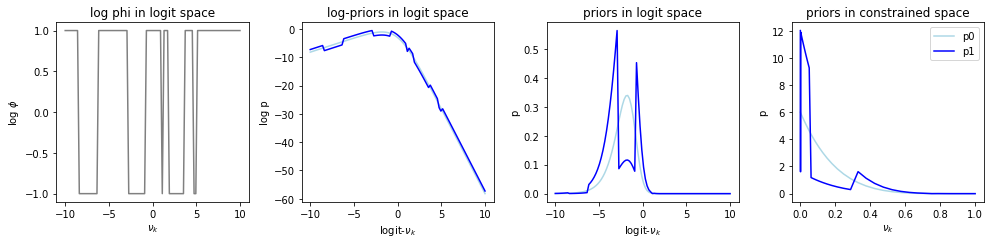

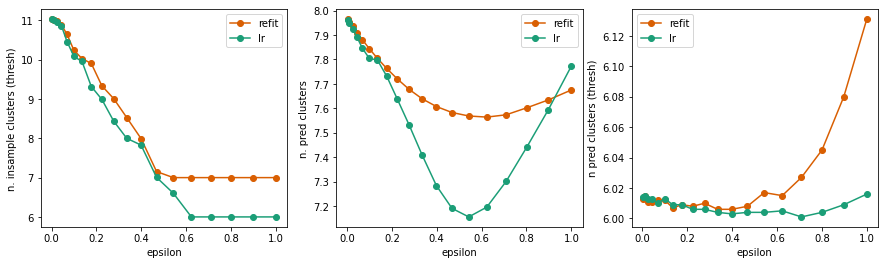

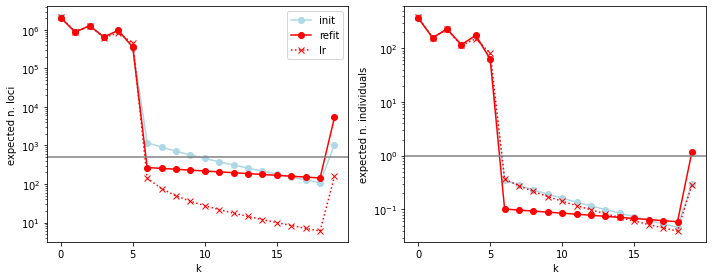

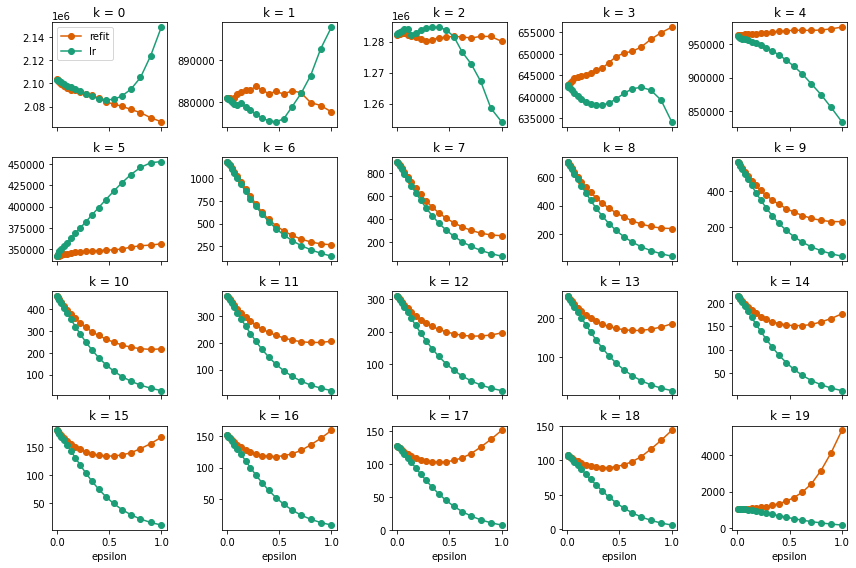

In [46]:
perturbation = 'worst_case'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


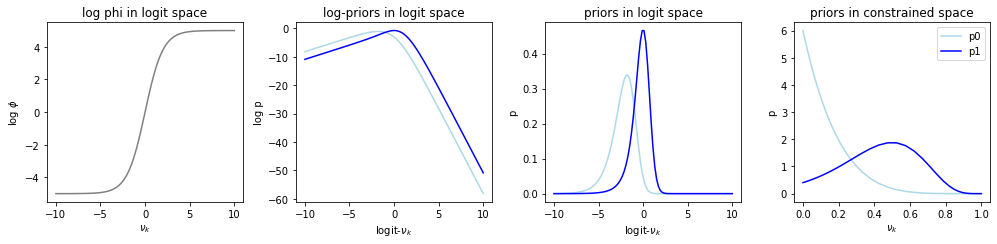

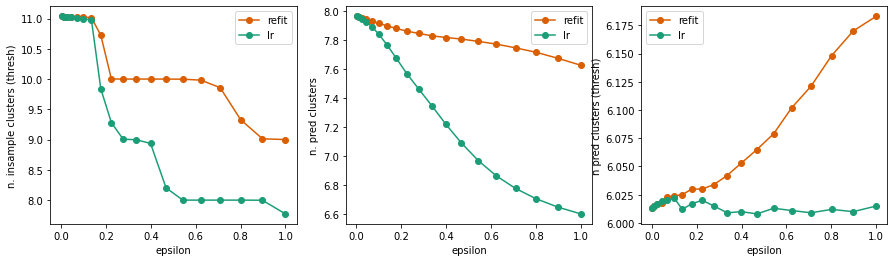

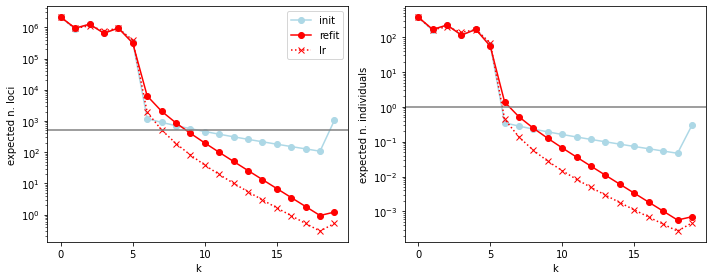

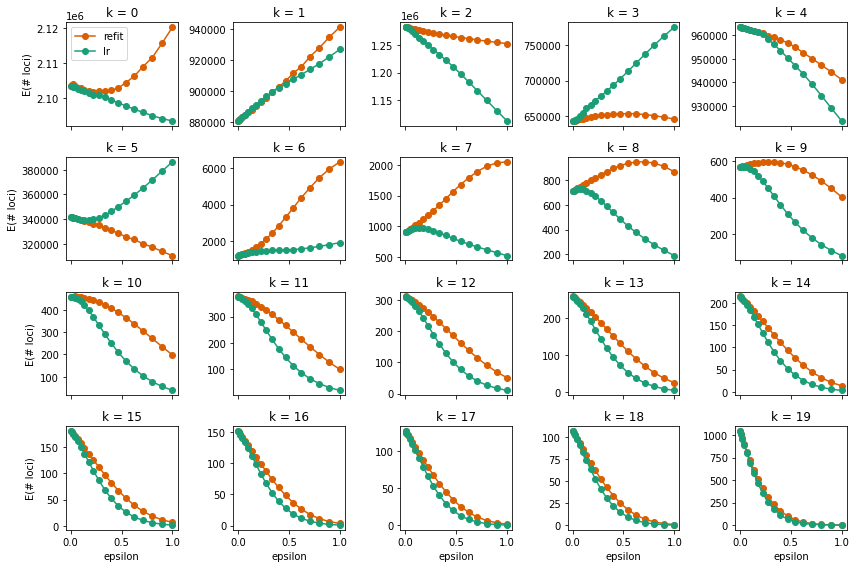

In [56]:
perturbation = 'sigmoidal'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


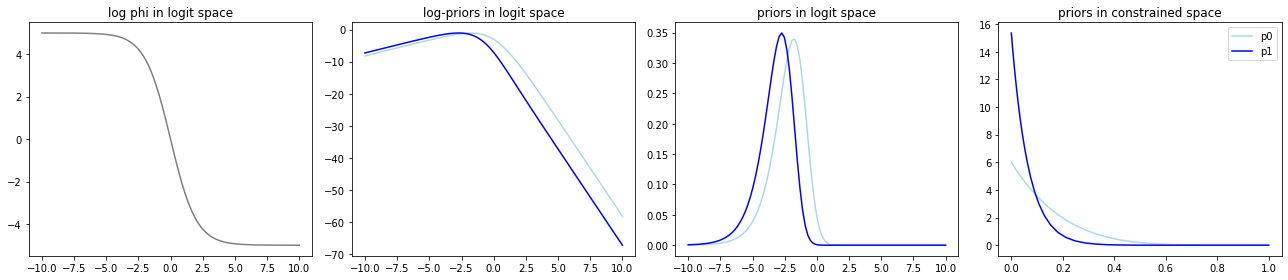

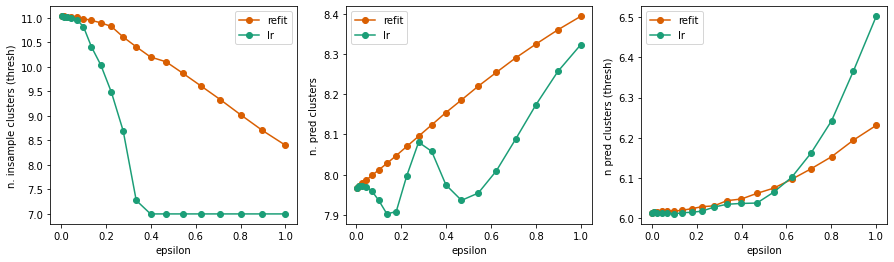

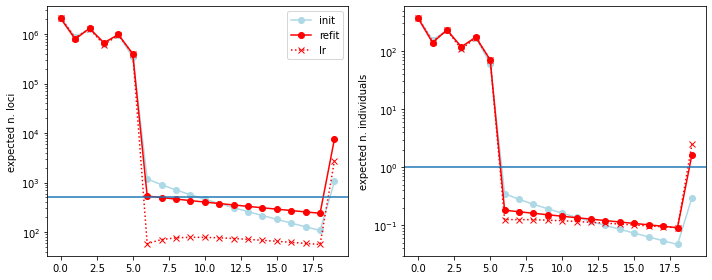

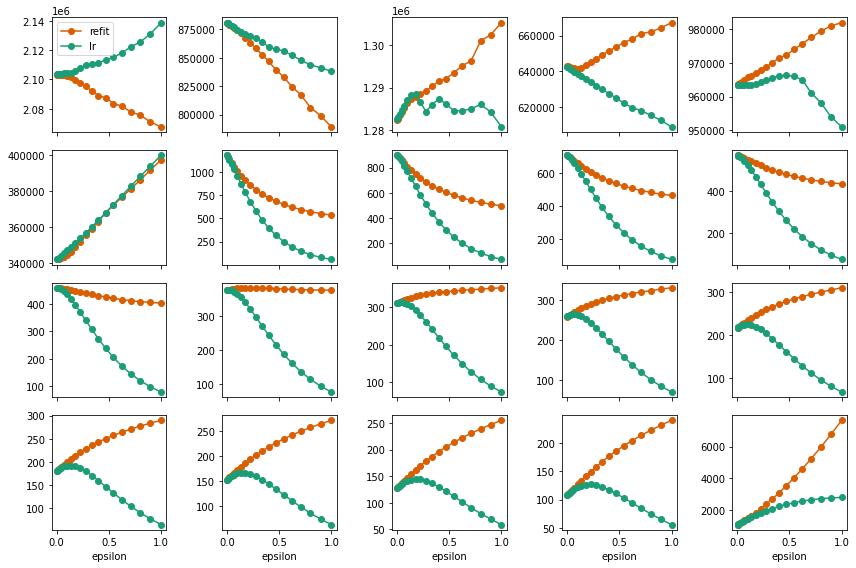

In [23]:
perturbation = 'sigmoidal_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


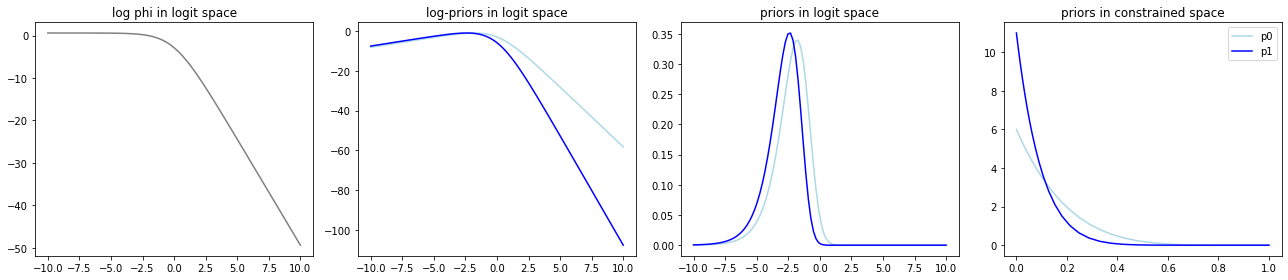

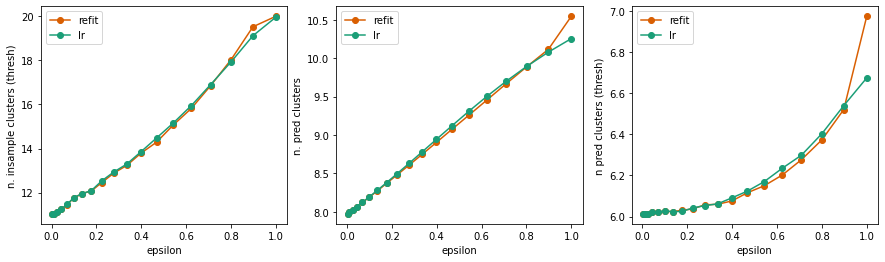

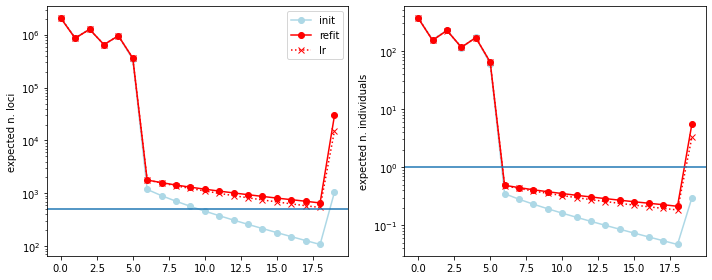

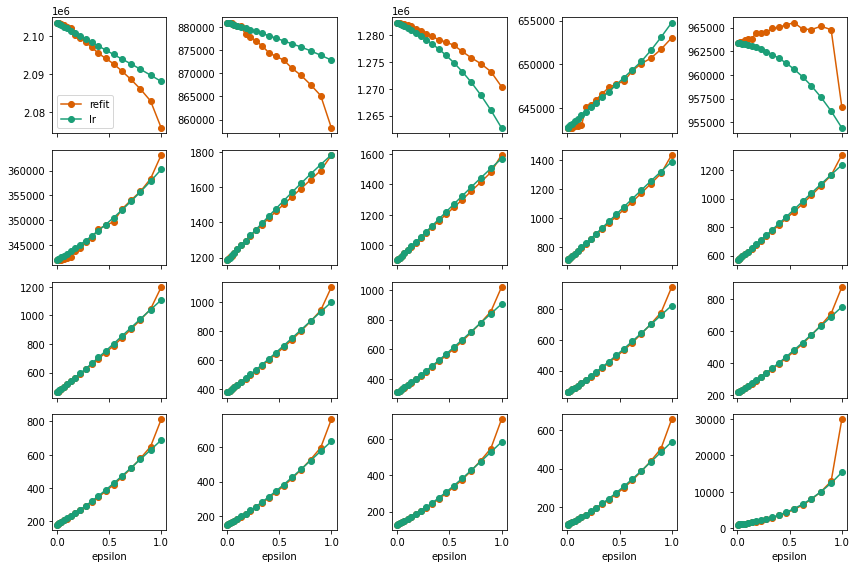

In [24]:
perturbation = 'alpha_pert_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


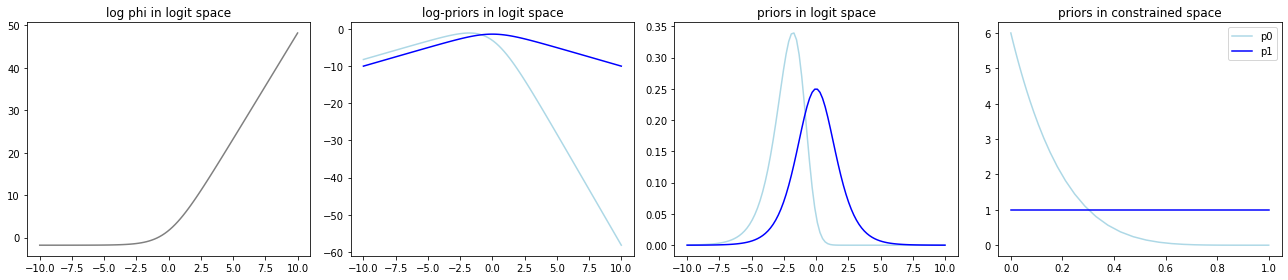

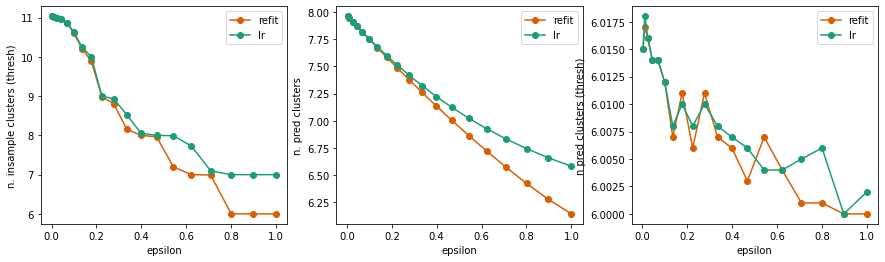

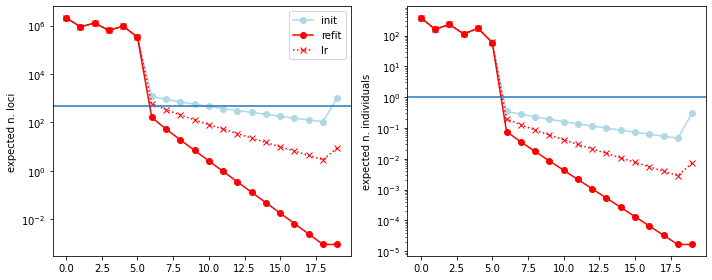

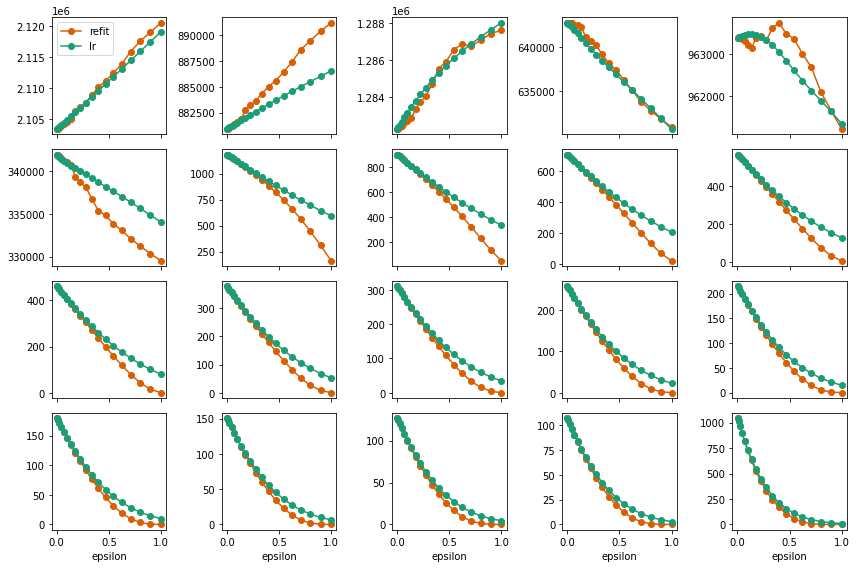

In [25]:
perturbation = 'alpha_pert_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.091946e-08
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


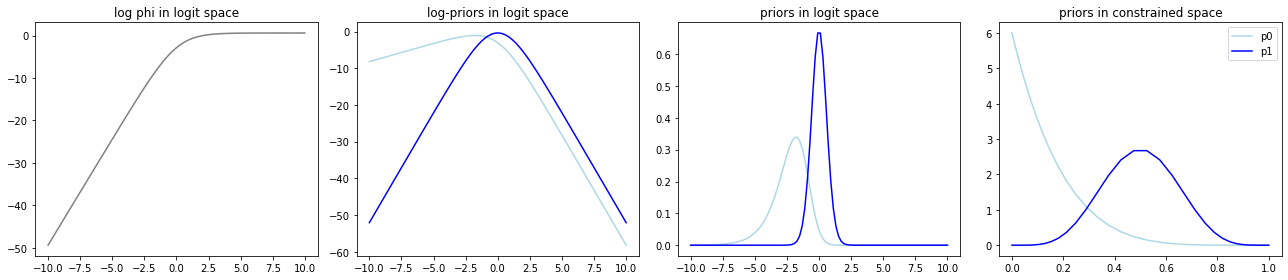

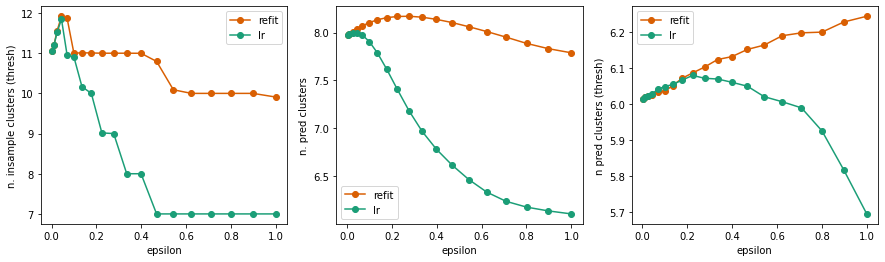

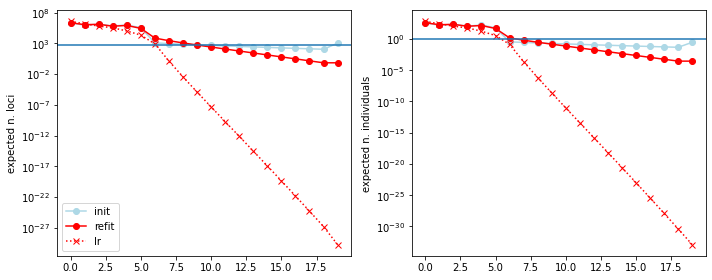

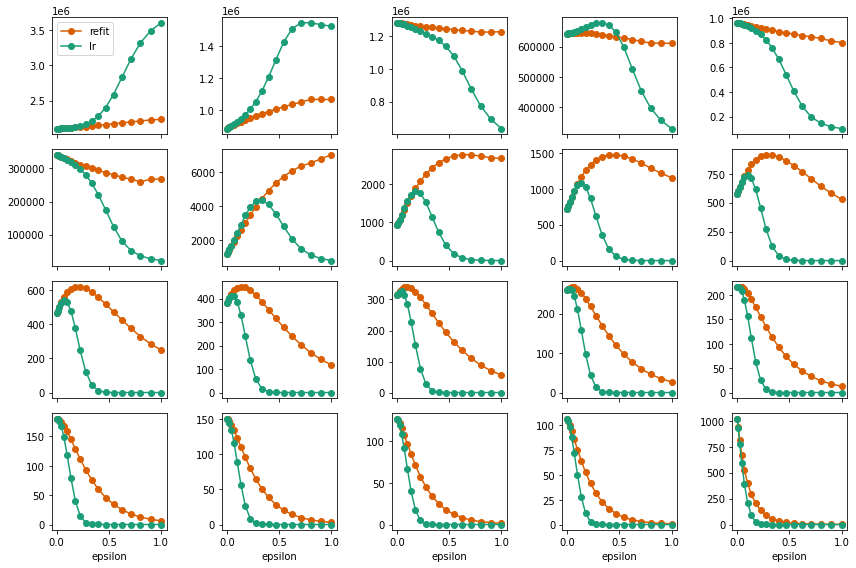

In [26]:
perturbation = 'alpha_pert_pos_xflip'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

In [27]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_e_num_clusters_for_perturbation(perturbation)
# plot_e_num_obs_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


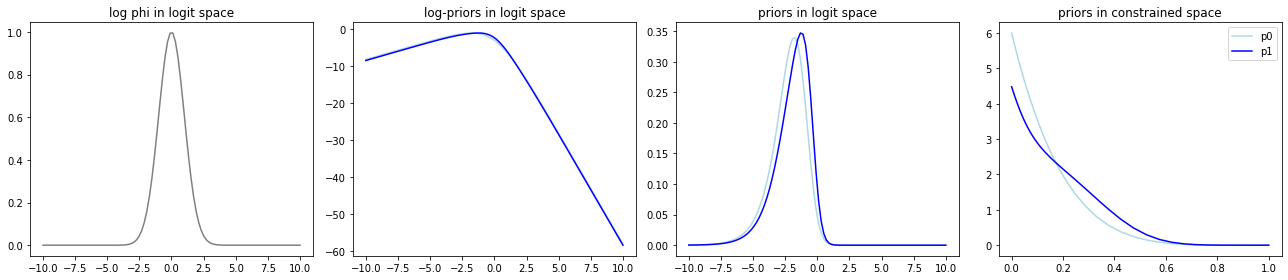

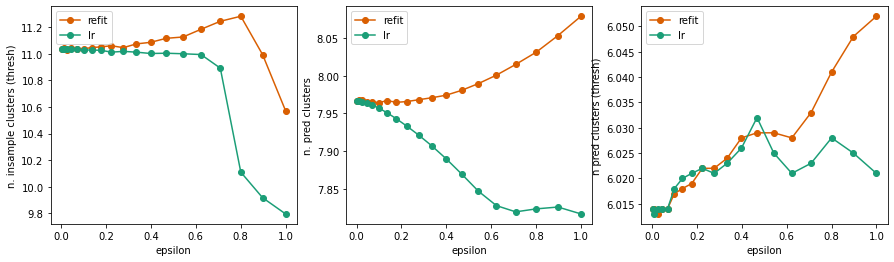

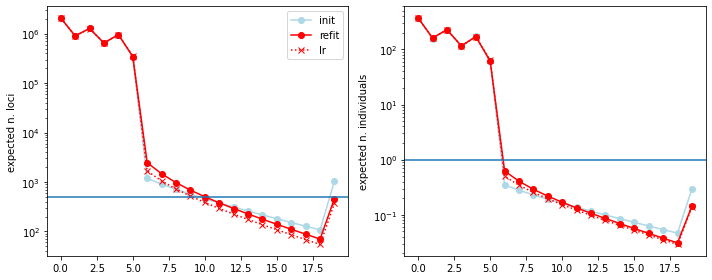

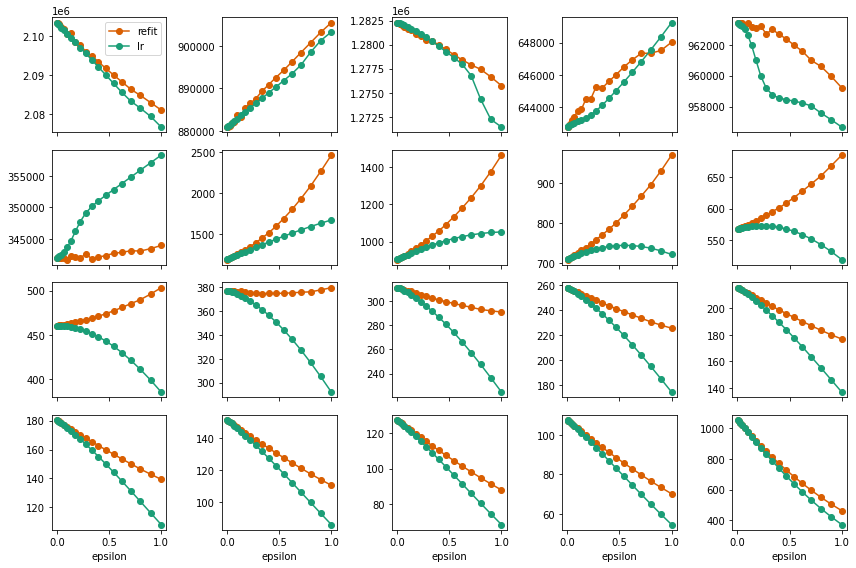

In [28]:
perturbation = 'gauss_pert1_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


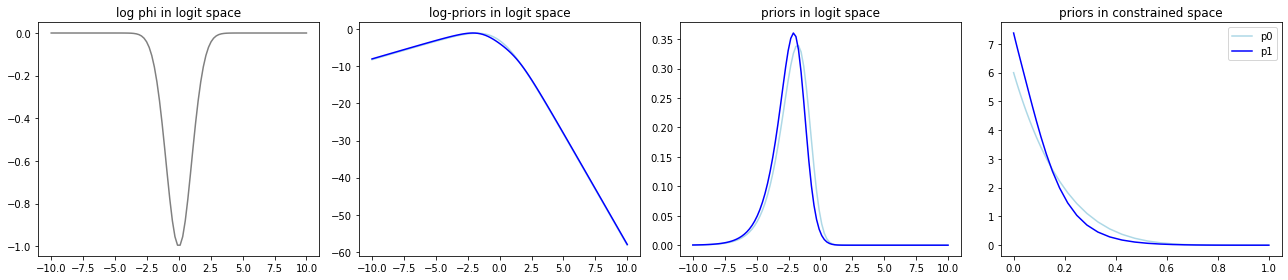

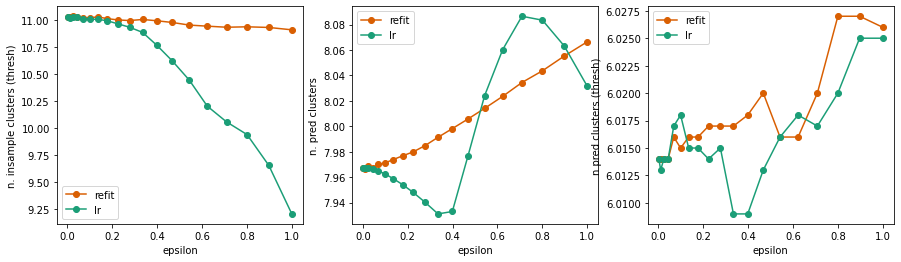

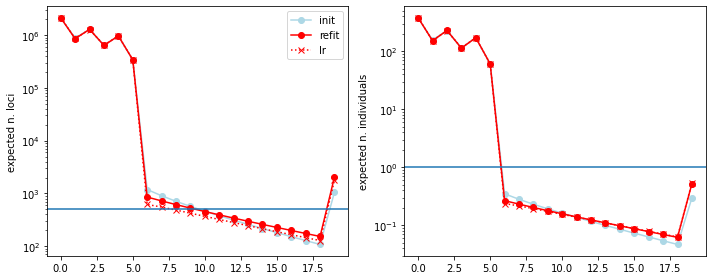

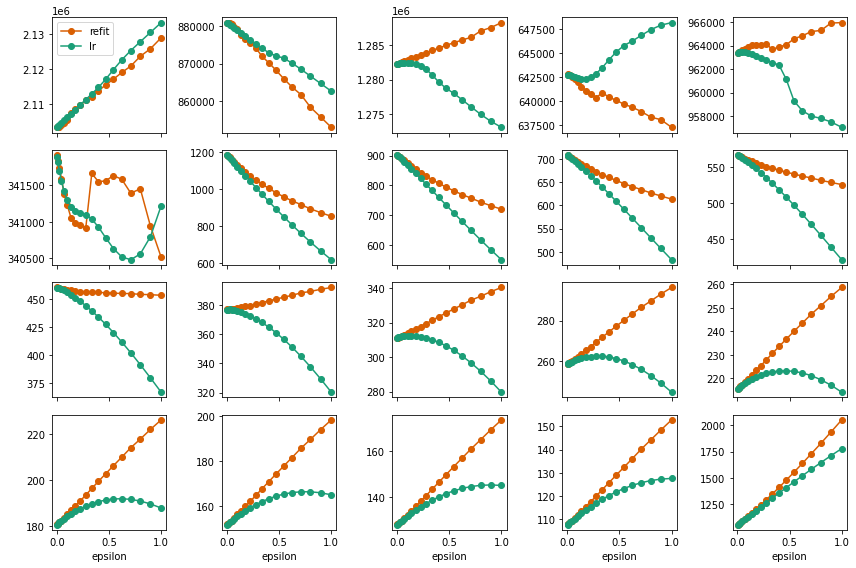

In [29]:
perturbation = 'gauss_pert1_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


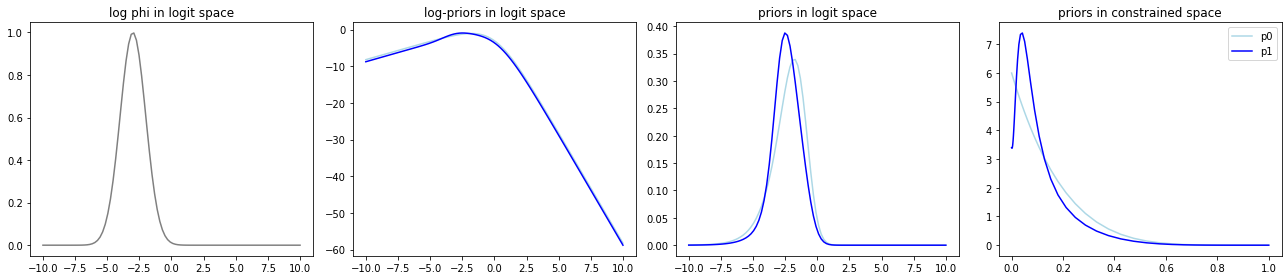

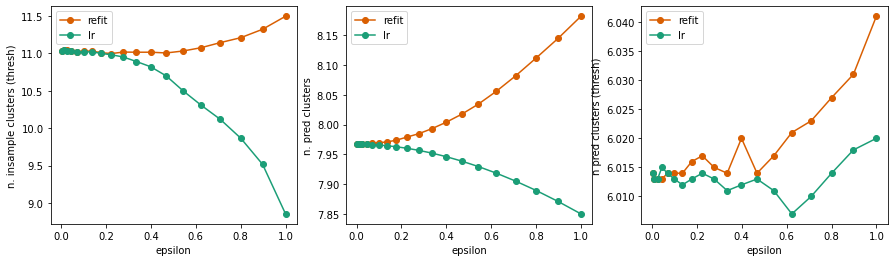

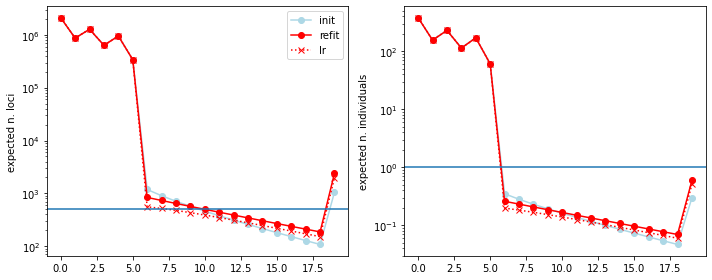

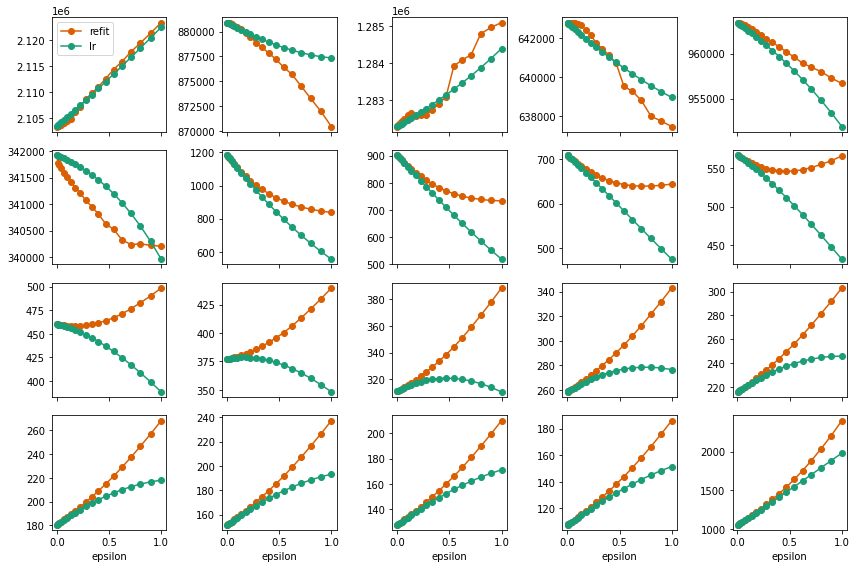

In [30]:
perturbation = 'gauss_pert2_pos'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


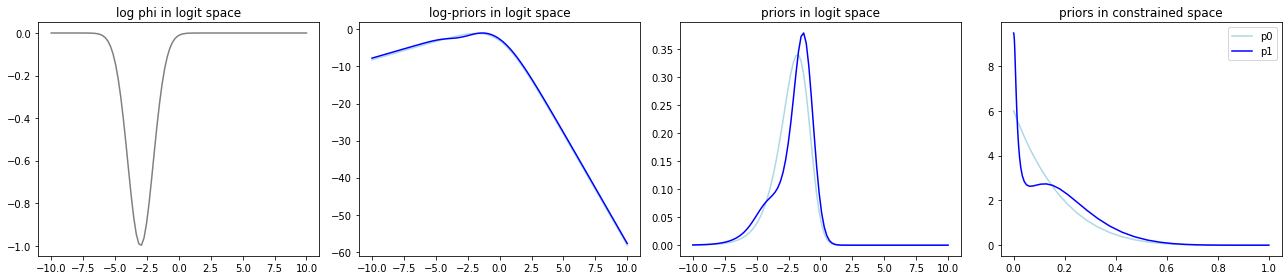

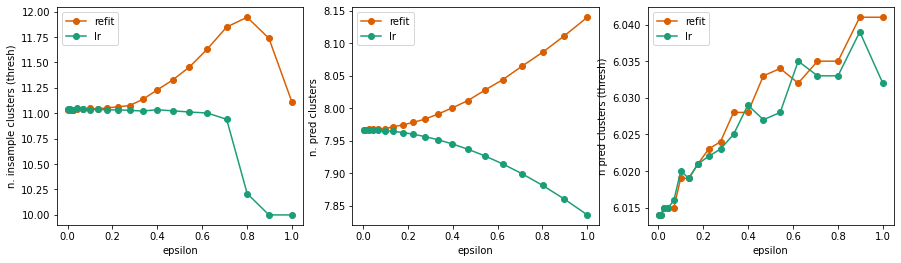

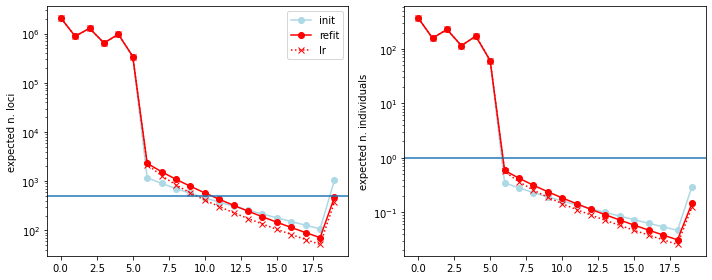

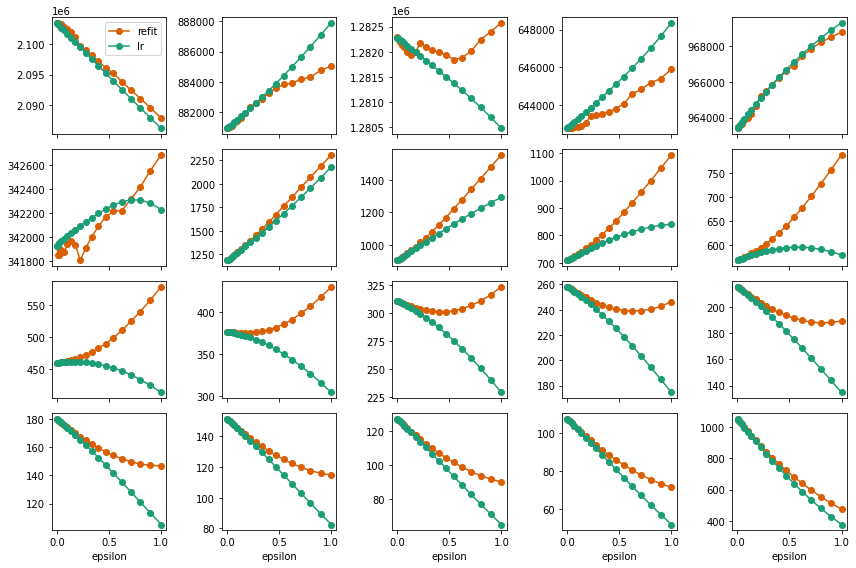

In [31]:
perturbation = 'gauss_pert2_neg'
plot_perturbation(perturbation)
plot_e_num_clusters_for_perturbation(perturbation)
plot_e_num_obs_for_perturbation(perturbation)
plot_e_num_obs_trace_for_perturbation(perturbation)

# Figures for meeting w Mike

In [59]:
def plot_figures_for_mike(perturbation): 
    
    # get prior perturbation
    # ignore that this also plots somthing ..
    prior_pert = plot_perturbation(perturbation)


    fig, ax = plt.subplots(1, 4, figsize = (14, 3.2)) 

    # get x-axis
    logit_v_grid = np.linspace(prior_pert.logit_v_lb, 
                               prior_pert.logit_v_ub,
                               100)

    v_grid = sp.special.expit(logit_v_grid)

    ###################
    # plot log-phi
    ###################
    ax[0].plot(logit_v_grid, 
               prior_pert.log_phi(logit_v_grid), 
               color = 'grey', 
               label = 'log-phi')
    ax[0].set_title('log phi in logit space')
    ax[0].set_xlabel(r'$\nu_k$')
    ax[0].set_ylabel(r'log $\phi$')

    ##################
    # plot priors
    ##################
    ax[1].set_title('priors in constrained space')
    ax[1].set_xlabel(r'$\nu_k$')
    ax[1].set_ylabel(r'p')
    ax[1].plot(v_grid, 
               np.exp(prior_pert.get_log_p0(v_grid)),
               color = 'lightblue', 
               label = 'p0')
    ax[1].plot(v_grid, 
               np.exp(prior_pert.get_log_pc(v_grid)), 
               color = 'blue', 
               label = 'p1')

    ax[1].legend()


    ##################
    # Plot expected number of clusters
    ##################
    nc_refit_vec, npc_refit_vec, npct_refit_vec,\
            nc_lr_vec, npc_lr_vec, npct_lr_vec,\
                epsilon_vec = load_e_num_clusters_vec(perturbation)

    plot_e_num_clusters(refit_vec = nc_refit_vec, 
                        lr_vec = nc_lr_vec, 
                        epsilon_vec = epsilon_vec, 
                        ax = ax[2], 
                        ylab = 'E(# thresh. clusters)')
    ax[2].set_title('expected number of (thresh.) clusters')

    ##################
    # Plot expected number of loci
    ##################
    e_n_loci_refit, e_n_ind_refit, \
        e_n_loci_lr, e_n_ind_lr, _ = \
            load_e_num_obs_all(perturbation)

    which_epsilon = -1

    k_approx = len(e_n_loci_refit[which_epsilon])

    # number of loci    
    plot_e_num_obs(e_n_loci_refit[which_epsilon], 
                   e_n_loci_lr[which_epsilon], 
                   e_n_loci_init, 
                   ax[3], 
                   thresh = 500., 
                   ylab = 'E(# loci)')
    ax[3].set_title('expected number of loci per cluster')

    fig.tight_layout()


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


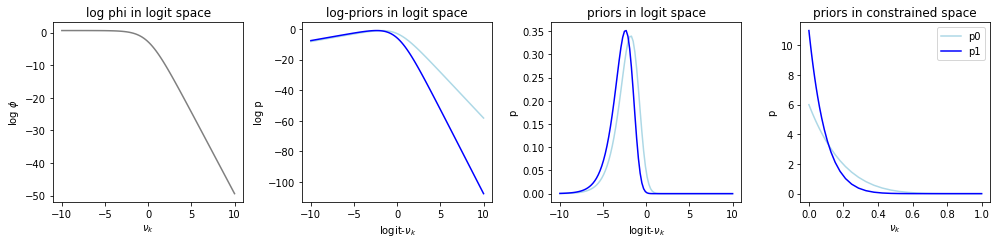

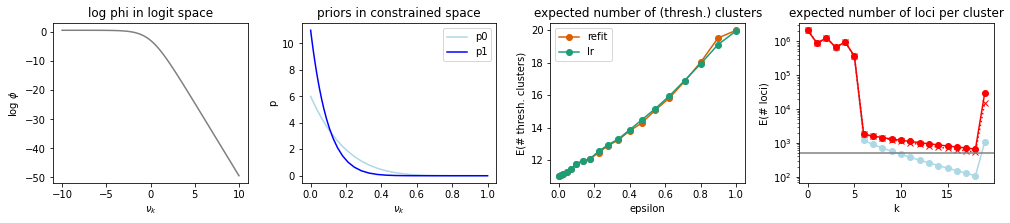

In [60]:
perturbation = 'alpha_pert_pos'
plot_figures_for_mike(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


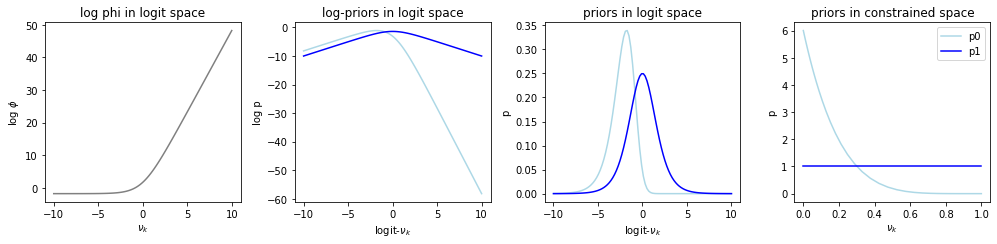

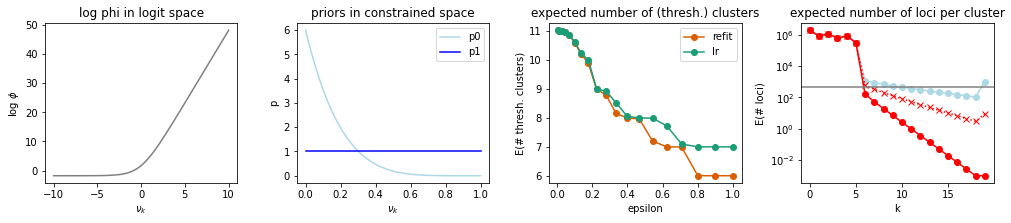

In [61]:
perturbation = 'alpha_pert_neg'
plot_figures_for_mike(perturbation)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/numpy/lax_numpy.py:3350: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


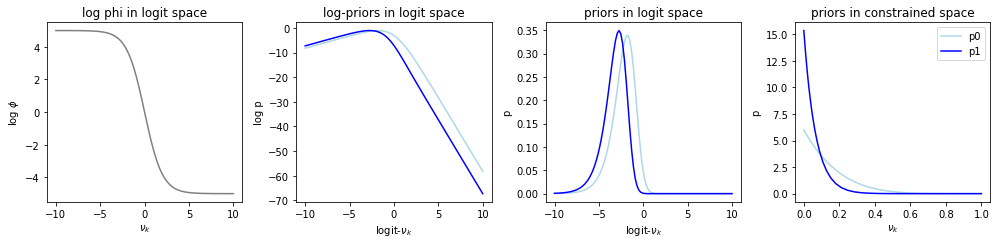

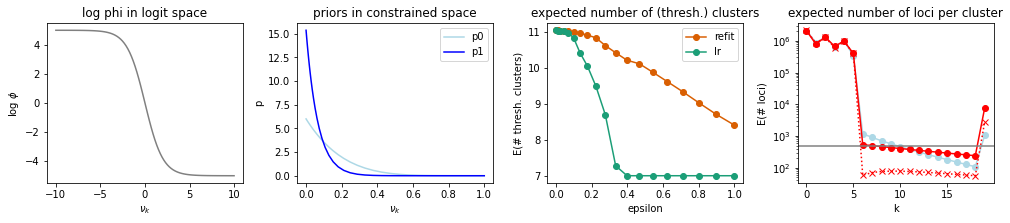

In [64]:
perturbation = 'sigmoidal_neg'
plot_figures_for_mike(perturbation)